In [4]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# globally silence FutureWarning messages
warnings.filterwarnings("ignore", category=FutureWarning)

In [41]:
otu_path = r"C:\Users\aburg\Documents\calculations\rmqs_exploration\data\rmqs1_16S_otu_abundance.tsv.gz"
otu_df = pd.read_csv(otu_path, sep="\t", index_col="id_site", compression="gzip", low_memory=False, encoding='windows-1252')
otu_df.index = otu_df.index.astype(str)

In [5]:
metadata_path = r"C:\Users\aburg\Documents\calculations\rmqs_exploration\data\RMQS1_occupation_nommatp_nomsol_23_03_2022.csv"
metadata_df = pd.read_csv(metadata_path, index_col="id_site", encoding='windows-1252')
metadata_df.index = metadata_df.index.astype(str)
metadata_df.columns

Index(['no_campagne', 'date_complete', 'insee_commune', 'nom_commune',
       'code_dept', 'site_officiel', 'x_theo', 'y_theo',
       'classe_mat1p_million_dexpert', 'libelle_mat1p_million_dexpert',
       'classe_mat2p_million_dexpert', 'libelle_mat2p_million_dexpert',
       'classe_mat3p_million_dexpert', 'libelle_mat3p_million_dexpert',
       'rp_95_nom', 'rp_2008_nom', 'rp_95_ger', 'signific_ger_95',
       'rp_2008_ger', 'signific_ger_2008', 'occupation1',
       'desc_code_occupation1', 'occupation3', 'desc_code_occupation3'],
      dtype='object')

In [43]:
metadata_df['signific_ger_95'].unique()

array(['THALASSOSOL-REDOXISOL', 'CALCOSOL-REDOXISOL', 'BRUNISOL',
       'BRUNISOL-REDOXISOL', 'NEOLUVISOL-REDOXISOL', 'PELOSOL BRUNIFIE',
       'NEOLUVISOL', 'FLUVIOSOL-REDOXISOL', 'RENDOSOL', 'CALCOSOL',
       'FLUVIOSOL BRUNIFIE', 'COLLUVIOSOL', 'REDUCTISOL',
       'ALOCRISOL TYPIQUE', 'FLUVIOSOL', 'THALASSOSOL', 'LUVISOL TYPIQUE',
       'RANKOSOL', 'LUVISOL', 'CALCISOL', 'LUVISOL-REDOXISOL',
       'LUVISOL DEGRADE', 'BRUNISOL OLIGO-SATURE', 'BRUNISOL SATURE',
       'ALOCRISOL', 'REDOXISOL', 'ALOCRISOL HUMIQUE', 'FLUVIOSOL TYPIQUE',
       'PELOSOL', 'PEYROSOL', 'ARENOSOL', 'HISTOSOL', 'LITHOVERTISOL',
       'PELOSOL DIFFERENCIE', 'BRUNISOL MESOSATURE', 'PODZOSOL MEUBLE',
       'CALCISOL-CALCOSOL', 'PLANOSOL TYPIQUE', 'PSEUDO-LUVISOL',
       'MAGNESISOL', 'PODZOSOL', 'ANTHROPOSOL RECONSTITUE',
       'PEYROSOL PIERRIQUE', 'LUVISOL TRONQUE', 'RENDISOL',
       'BRUNISOL-REDUCTISOL', 'DOLOMITOSOL', 'LITHOSOL',
       'PODZOSOL DURIQUE', 'REDUCTISOL TYPIQUE', 'CALCISOL-REDOXIS

In [45]:
pivot_type = metadata_df.groupby(['signific_ger_95']).size().rename('count').sort_values(ascending=False).to_frame()
pivot_type

,count
signific_ger_95,
BRUNISOL,402
CALCOSOL,321
CALCISOL,129
LUVISOL,114
NEOLUVISOL,106
...,...
QUASI-LUVISOL,1
REDOXISOL-LUVISOL,1
PSEUDO-LUVISOL-REDOXISOL,1


In [7]:
metadata_df.columns

Index(['no_campagne', 'date_complete', 'insee_commune', 'nom_commune',
       'code_dept', 'site_officiel', 'x_theo', 'y_theo',
       'classe_mat1p_million_dexpert', 'libelle_mat1p_million_dexpert',
       'classe_mat2p_million_dexpert', 'libelle_mat2p_million_dexpert',
       'classe_mat3p_million_dexpert', 'libelle_mat3p_million_dexpert',
       'rp_95_nom', 'rp_2008_nom', 'rp_95_ger', 'signific_ger_95',
       'rp_2008_ger', 'signific_ger_2008', 'occupation1',
       'desc_code_occupation1', 'occupation3', 'desc_code_occupation3'],
      dtype='object')

In [ ]:
pivot_type = df.groupby(['wrb_guess']).size().rename('count').sort_values(ascending=False).to_frame()
pivot_type


,count
wrb_guess,
Cambisol,550
Calcisol,469
Luvisol,371
Leptosol,202
Alisol,125
Colluvic Regosol,93
Gleysol,93
Fluvisol,90
Podzol,63


In [8]:
mapping = pd.read_csv(r"c:\Users\aburg\Documents\calculations\rmqs_exploration\data\soil_data.csv")
df = metadata_df.merge(mapping, left_on='signific_ger_95', right_on="name", how="left", suffixes=('', '_soil'))
df.head()

,no_campagne,date_complete,insee_commune,nom_commune,code_dept,site_officiel,x_theo,y_theo,classe_mat1p_million_dexpert,libelle_mat1p_million_dexpert,...,stony,vertic,shallow,anthropic,volcanic,truncated,cemented,base_saturation,qualifier_notes,classe_simplifiee
0,1,10/09/2002,59016,ARMBOUTS-CAPPEL,59,True,652326.99,7101219.71,120,Estuarine/Marine alluvium,...,False,false,false,False,False,False,False,unknown,marine influence; redox features,limoneux
1,1,02/09/2002,59404,LES MOERES,59,True,668319.25,7101085.53,120,Estuarine/Marine alluvium,...,False,false,false,False,False,False,False,unknown,marine influence; redox features,limoneux
2,1,02/07/2003,62806,TARDINGHEN,62,True,604216.81,7085629.01,230,Marl,...,False,false,false,False,False,False,False,high,calcareous; redox features,calcaire
3,1,16/09/2003,62397,GUINES,62,True,620208.83,7085495.39,510,Residual loam,...,False,false,false,False,False,False,False,medium,cambic features,intermediaire
4,1,17/09/2003,62906,ZUTKERQUE,62,True,636200.84,7085361.59,510,Residual loam,...,False,false,false,False,False,False,False,medium,cambic + redox features,intermediaire


In [ ]:
def make_custom(row):
    if row['desc_code_occupation1'] == 'surfaces boisees':
        if row['desc_code_occupation3'] == 'forets caducifoliees':
            return row['desc_code_occupation3']
        return 'forets de coniferes' 
    return row['desc_code_occupation1']

meta_sel = metadata_df[['desc_code_occupation1', 'desc_code_occupation3']].copy()
meta_sel['land_use'] = meta_sel.apply(make_custom, axis=1)

In [ ]:
#convert abundance to richness (presence absence)
otu_counts = (otu_df > 0).astype(bool).sum(axis=1).astype(int)
otu_counts.name = "otu_richness"
otu_counts = otu_counts.to_frame()
result_df = otu_counts.join(meta_sel['land_use'], how='inner')

In [ ]:
otu_counts.to_csv(r"C:\Users\aburg\Documents\calculations\rmqs_exploration\results\otu_richness.csv", index=True, sep=';')

In [ ]:
pivot = result_df.pivot_table(values='otu_richness', index='land_use', aggfunc='mean')
pivot = pivot.sort_values('otu_richness', ascending=False)

print("Average OTU richness by desc_code_occupation1:")
print(pivot.to_string(formatters={'otu_richness': lambda v: f"{v:,.0f}".replace(',', "'")}))

Average OTU richness by desc_code_occupation1:
                                               otu_richness
land_use                                                   
friches                                               2'308
parcs et jardins                                      2'308
vignes vergers et cultures perennes arbustives        2'246
successions culturales                                2'222
surfaces toujours en herbe                            2'147
milieux naturels particuliers                         2'081
forets caducifoliees                                  1'994
forets de coniferes                                   1'863


In [ ]:
result_df = result_df[result_df['desc_code_occupation1'] == "successions culturales"]
# order categories by median richness (descending)
medians = result_df.groupby('land_use')['otu_richness'].median().sort_values(ascending=False)
order = medians.index.tolist()

# portrait figure (taller than wide) — height scales with number of categories
fig_w, fig_h = 8, max(8, 0.35 * len(order))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# thicker violins: increase width and linewidth, remove inner to avoid clutter
sns.violinplot(x='otu_richness', y='land_use', data=result_df,
               order=order, inner='quartile', scale='width', cut=0, palette='tab10')

# jittered points overlay (show individual sites) — use slightly larger points and semi-transparent
sns.stripplot(x='otu_richness', y='land_use', data=result_df,
              order=order, color='k', size=3.5, jitter=True, alpha=0.2, ax=ax)

# compute medians and annotate them next to the median markers
offset = max(medians.max() * 0.005, 0.5)  # horizontal offset for labels
fmt = lambda x, pos=None: f"{x:,.0f}".replace(',', "'") #number format function
for i, (cat, med) in enumerate(medians.items()):
    ax.text(med + offset, i, fmt(med), va='center', ha='left', fontsize=8, fontweight='bold', color='white')

# formatting
# counts per category for labels
counts = result_df.groupby('land_use').size().reindex(order).fillna(0).astype(int)
y_labels = [f"{cat} ({cnt}p)" for cat, cnt in zip(order, counts)]
ax.set_yticks(range(len(order)))
ax.set_yticklabels(y_labels)
ax.set_xlabel('OTU richness')
ax.set_ylabel('')
ax.set_title('Distribution of OTU richness by land‑use')

fmt = lambda x, pos: f"{x:,.0f}".replace(',', "'")
ax.xaxis.set_major_formatter(FuncFormatter(fmt))

plt.tight_layout()
out_path = r"c:\Users\aburg\Documents\calculations\rmqs_exploration\results\otu_richness_by_land_use_violin.png"
plt.savefig(out_path, dpi=300)
plt.show()

KeyError: 'desc_code_occupation1'

In [ ]:
pivot = meta_sel[meta_sel['desc_code_occupation1'] == "successions culturales"].groupby(['desc_code_occupation3']).size().rename('count').to_frame()

print(pivot)

                                                    count
desc_code_occupation3                                    
Successions culturales                                  1
grandes cultures                                       47
grandes cultures et prairies courte duree             191
horticulture ornementale herbacee et ligneux            1
jachere fixe                                           59
maraa®chage                                             9
monoculture                                            61
systeme de rotations sans prairie avec intercul...     78
systeme de rotations sans prairie sans intercul...    439


Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\distribution\distribution_otu_richness_by_land_use.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\distribution\distribution_otu_richness_by_parent_material.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\distribution\distribution_otu_richness_by_wrb_class.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\distribution\distribution_otu_richness_by_soil_type.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\distribution\distribution_otu_richness_by_land_use_fine.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_land_use.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_parent_material.png
Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_

KeyError: 'soil_class'

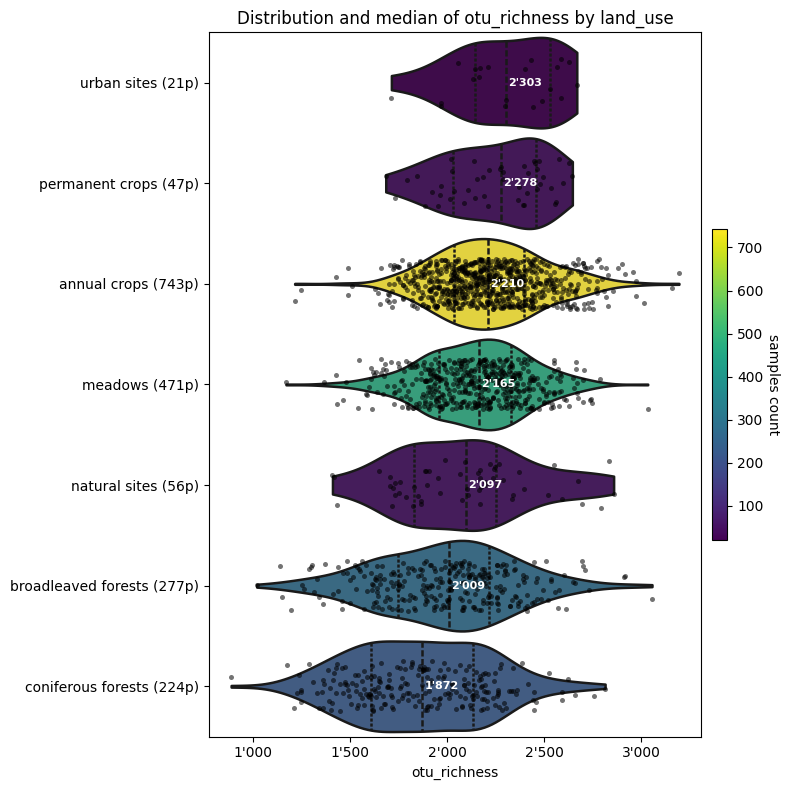

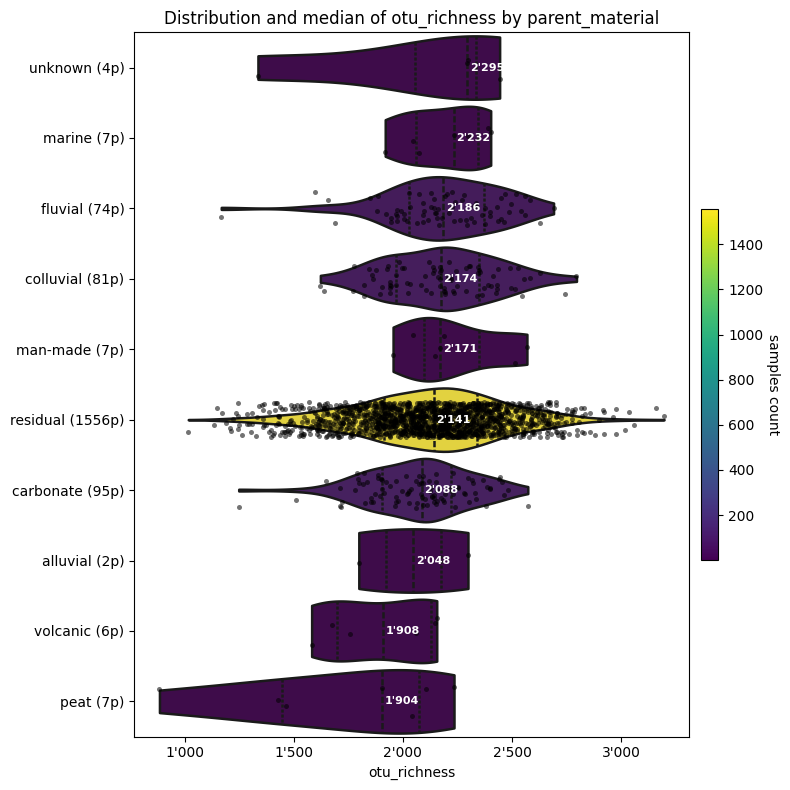

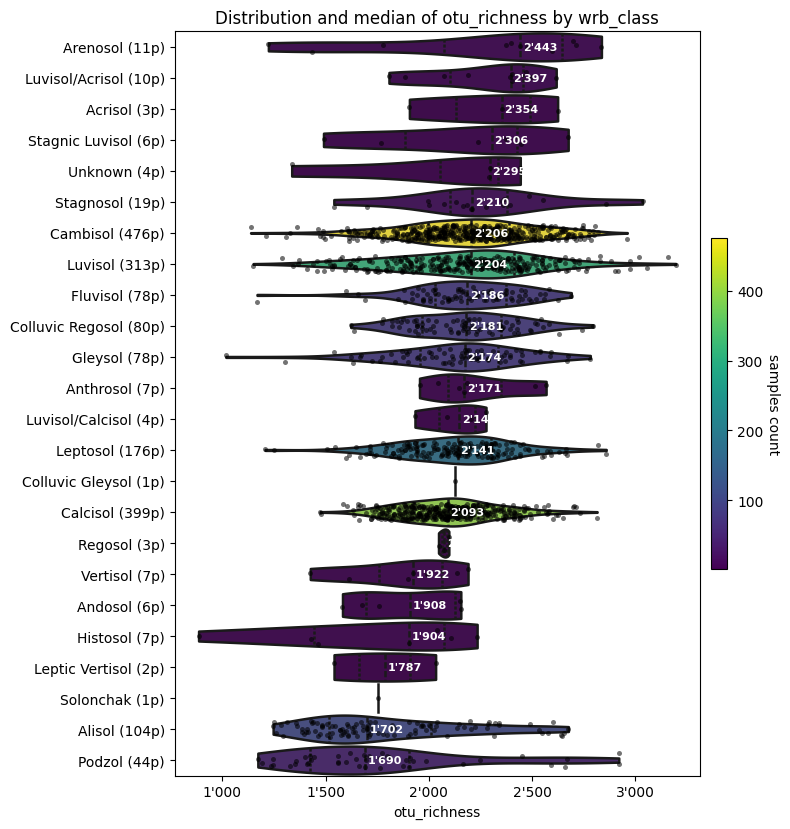

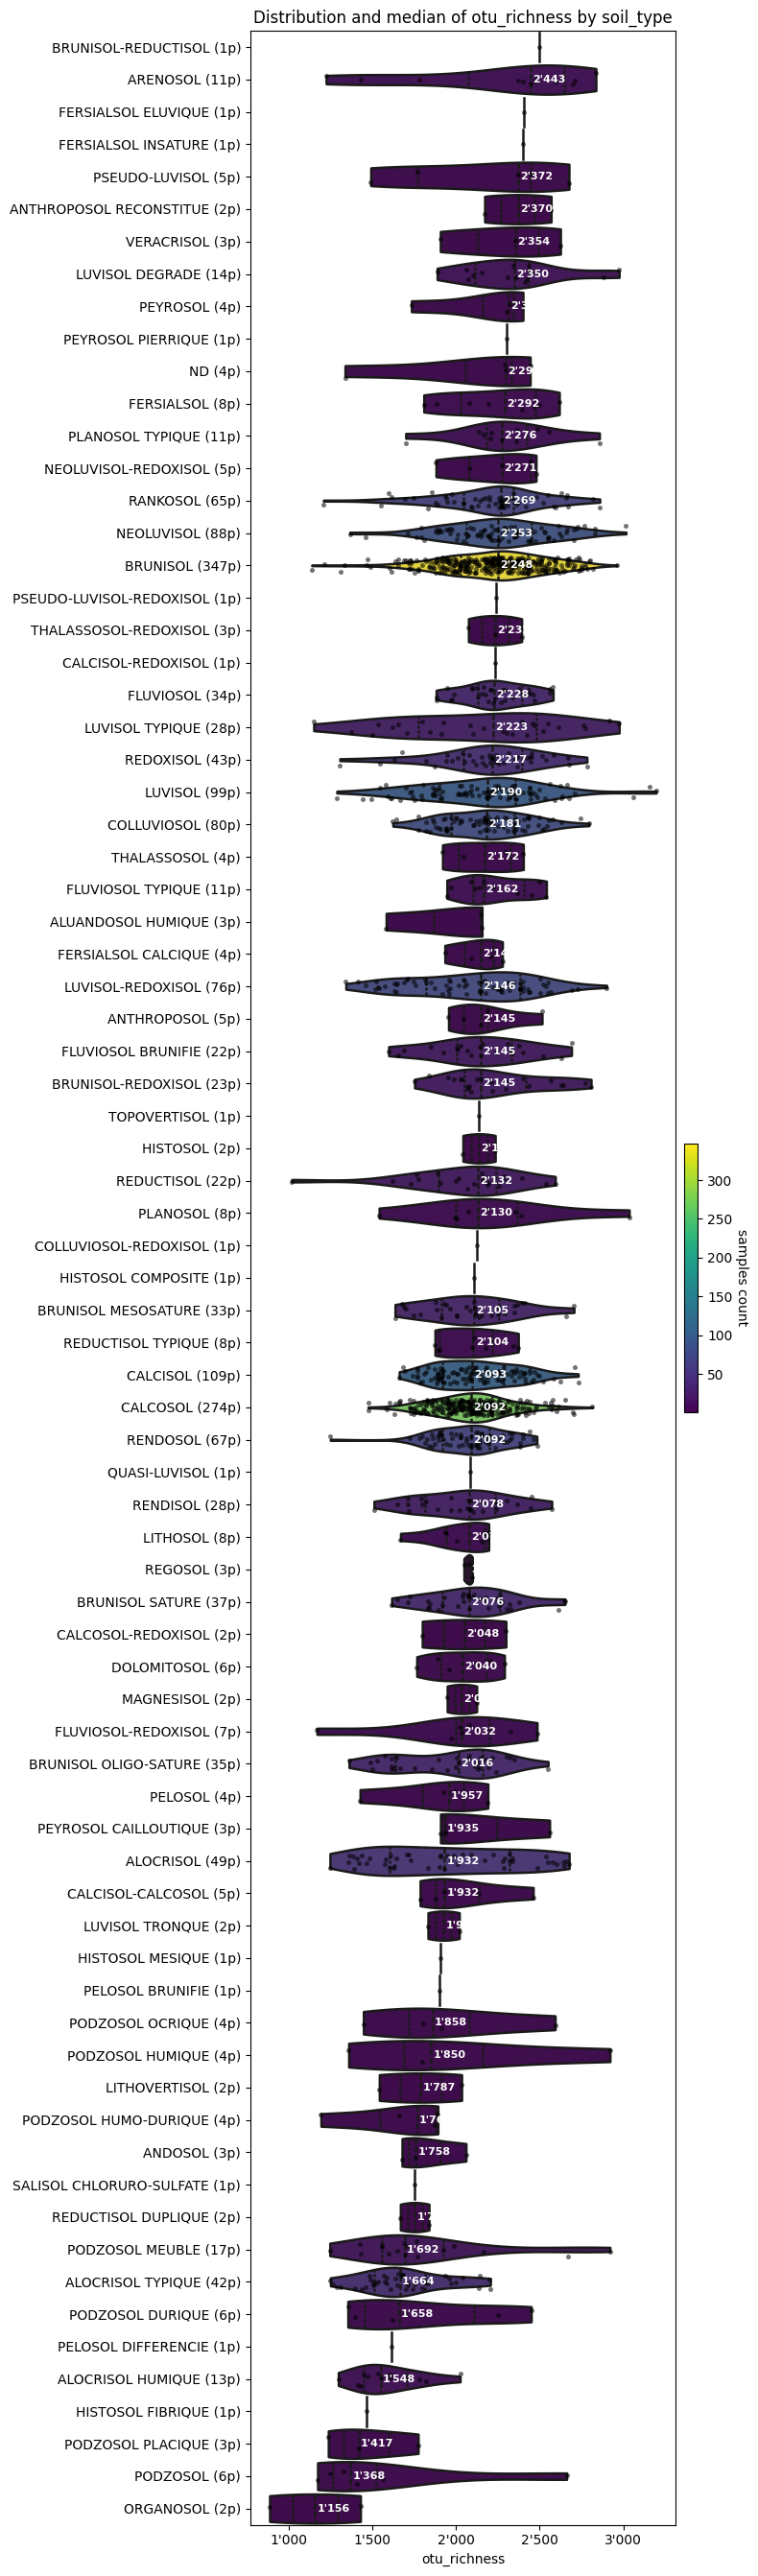

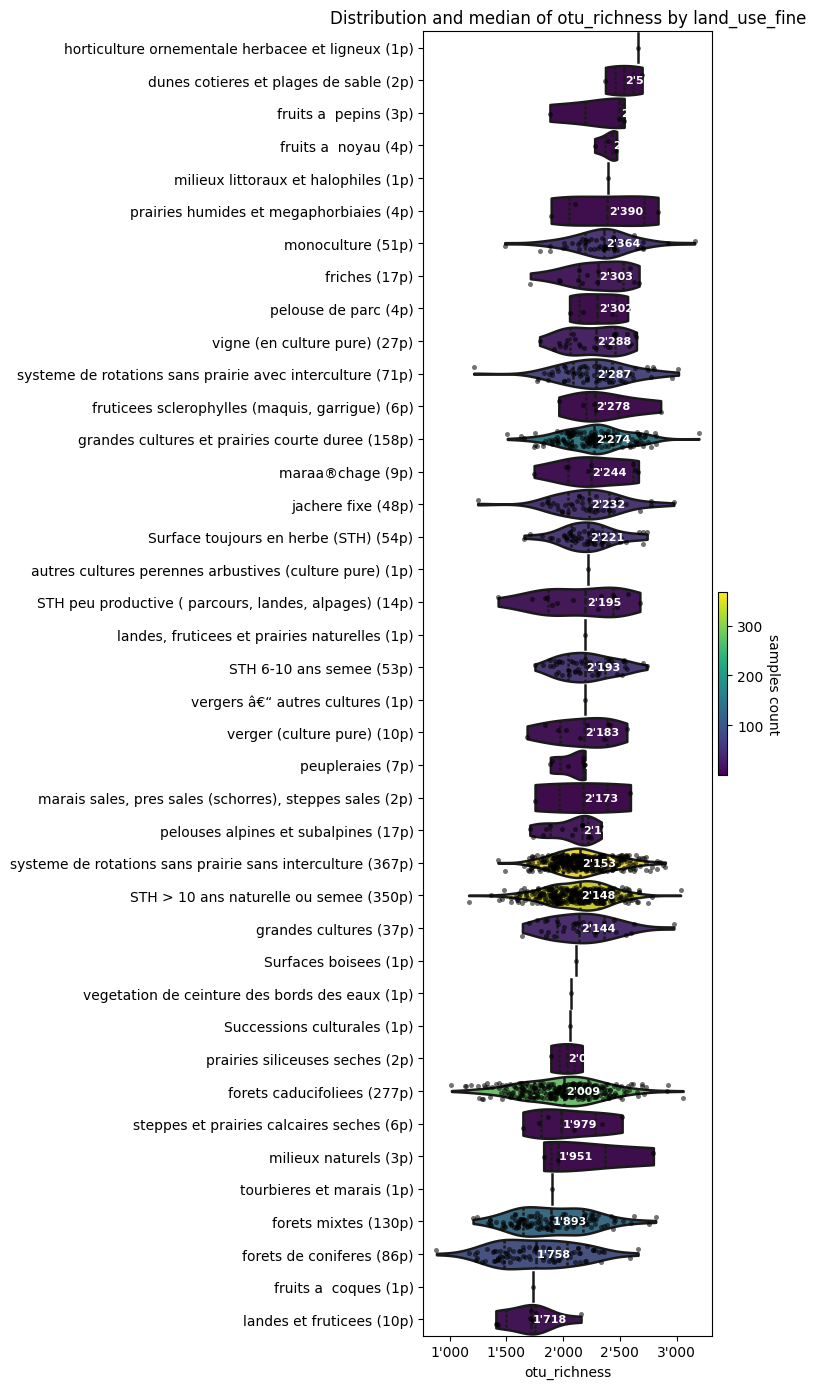

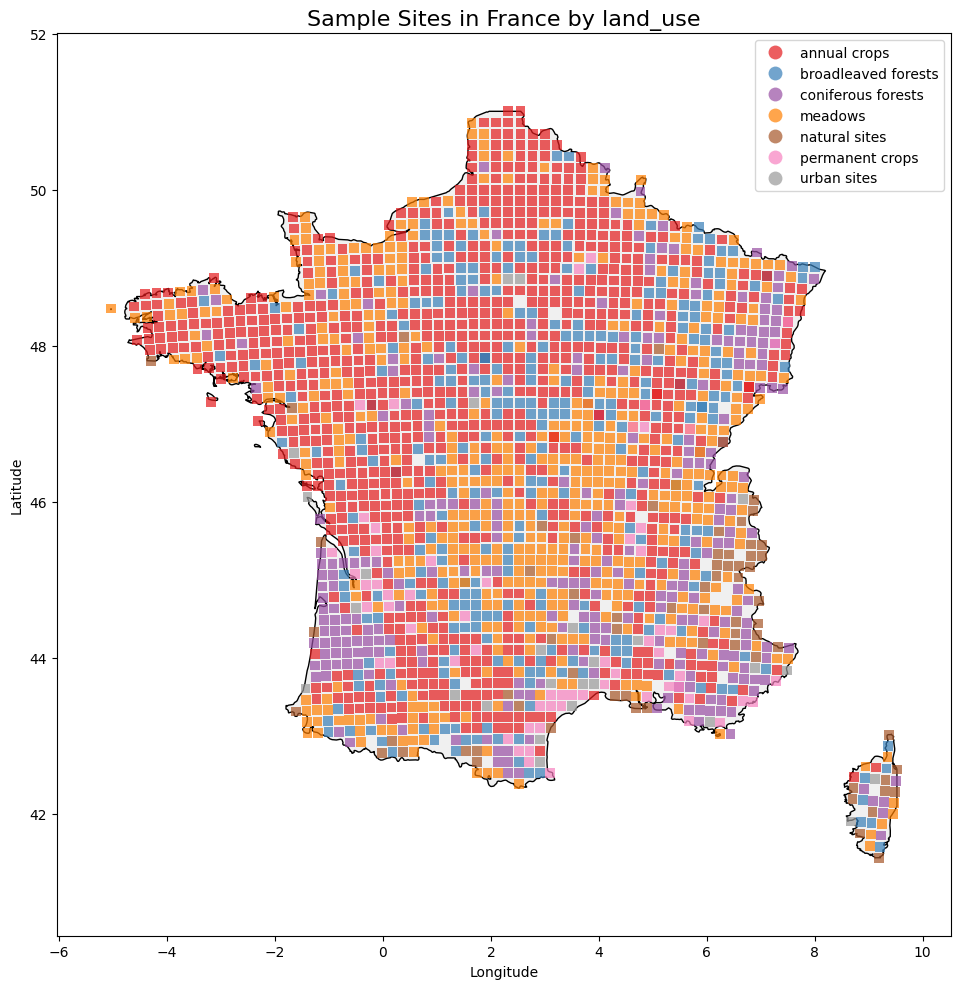

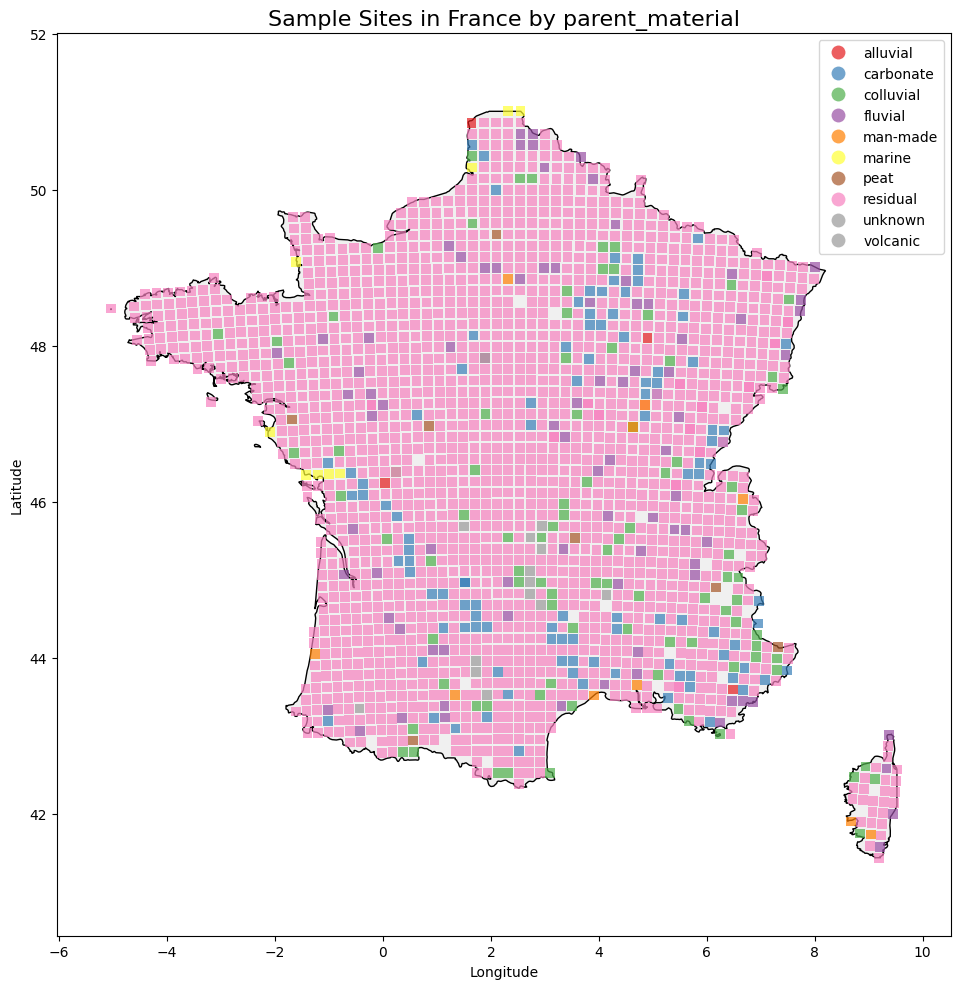

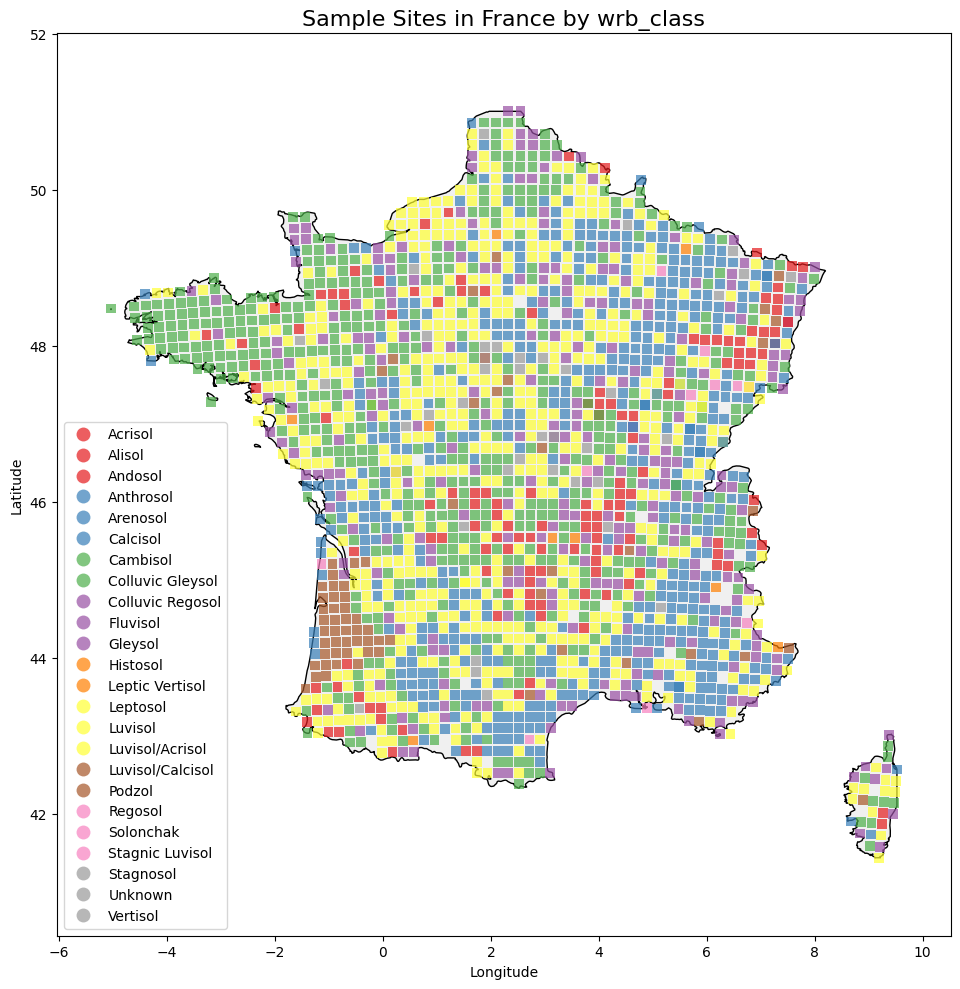

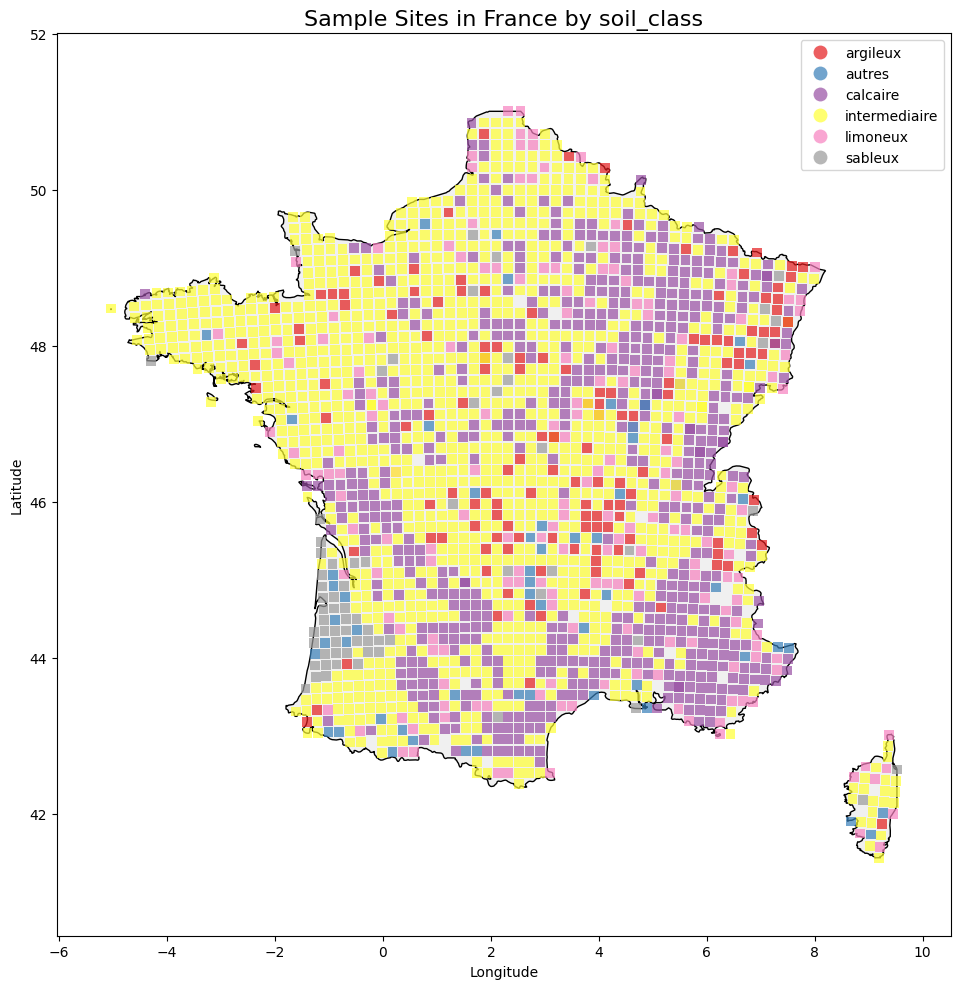

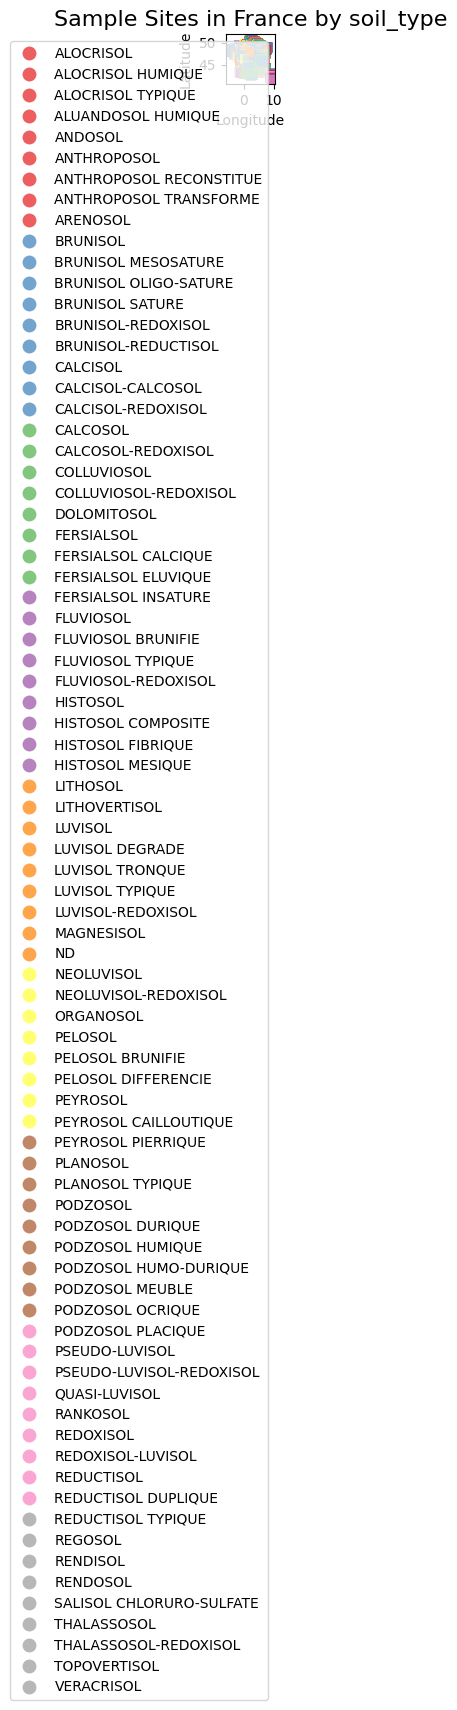

In [ ]:
import plot_distribution
import plot_map
import plot_heatmap

plot_distribution.main("otu_richness", "land_use", 'land_use')
plot_distribution.main("otu_richness", "parent_material", 'parent_material')
plot_distribution.main("otu_richness", "wrb_guess", 'wrb_class')
plot_distribution.main("otu_richness", "signific_ger_95", 'soil_type')
plot_distribution.main("otu_richness", "desc_code_occupation3", 'land_use_fine')

plot_map.main("land_use", 'land_use')
plot_map.main("parent_material", 'parent_material')
plot_map.main("wrb_guess", 'wrb_class')
plot_map.main("wrb_guess", 'soil_class')
plot_map.main("signific_ger_95", 'soil_type')

plot_heatmap.main("otu_richness", "land_use", 'soil_class')

Saved figure to: c:\Users\aburg\Documents\calculations\rmqs_exploration\results\map\map_france_soil_class.png


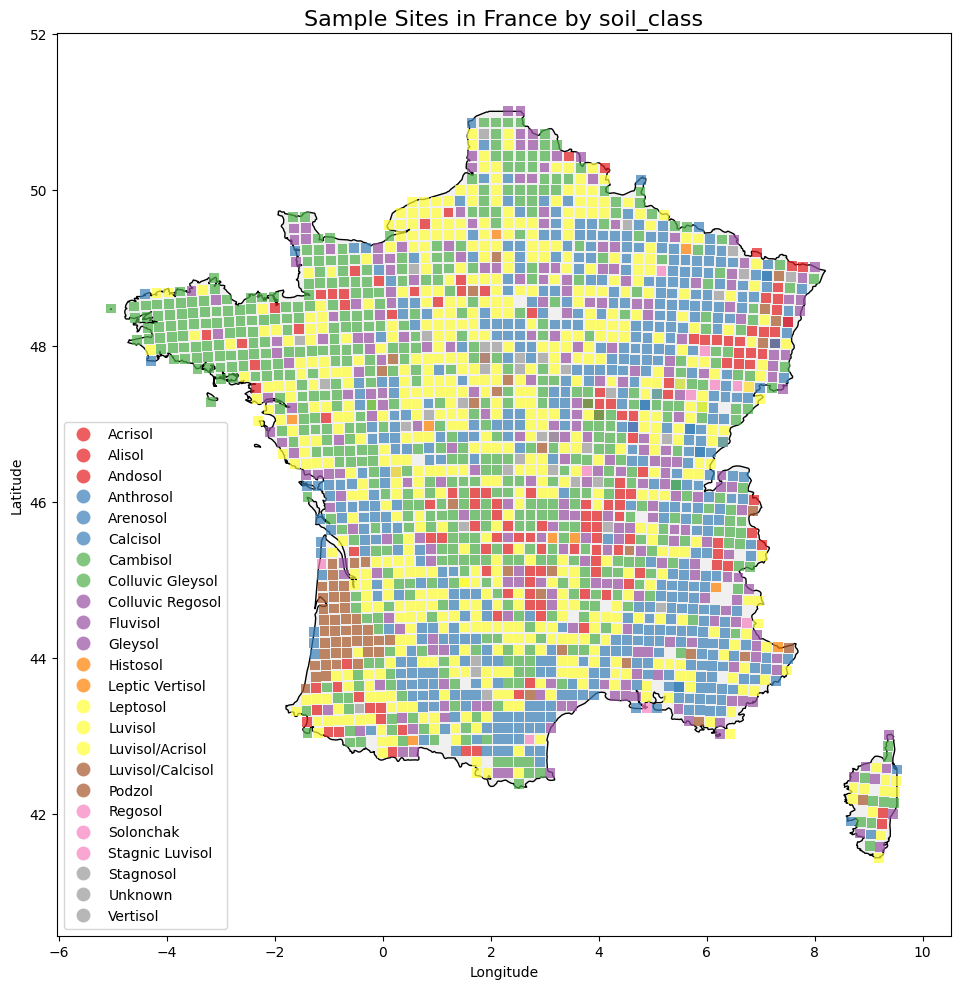

In [2]:
plot_map.main("wrb_guess", 'soil_class')